# Capstone: Detecting Aircraft from Satellite Imagery
## Part 3b - YOLOv8 Modelling
YOLOv8 is the latest model from Ultralytics, fresh out the oven on 10 Jan 2023. To find out more about YOLOv8's architecture and changes please read [What is YOLOv8?](https://blog.roboflow.com/whats-new-in-yolov8/)  
This notebook runs through the process of fine tuning the yolov8 model on the dataset that we have processed in parts 1 and 2.
---

**yolov8 conveniently has a pip installable library, making it more familiar to use in a python environment.**

In [1]:
#! pip install ultralytics

import numpy as np
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
# set random seeds for reproducibility
random.seed(8888)
np.random.seed(8888)
pd.set_option('display.max_columns', None)  

## Load Pretrained Model

In [3]:
# Load a model
model = YOLO("yolov8/yolov8l.pt")  # load pretrained model yolov8l for transfer learning

Similarly to yolov7, image augmentations are by default included in the training. There is no need for autoanchor (anchor evolution tuning) due to it being an 'anchor-free' model This means it predicts directly the center of an object instead of the offset from a known anchor box.  
In addition, yolov8 training using the python API allows for easy deployment of albumentation functions such as Blur, MedianBlur, ToGray and CLAHE. *CLAHE refers to the technique 'Contrast Limited Adaptive Histogram Equalization' used for enhancing the local contrast of an image.*  

The yolo v8L model will be trained with the following specified arguments for **40 epochs**, and an early stopping callback with a patience of 10 epochs:

### Fine Tune the Model on Custom Dataset

In [4]:
# Use the model
# train_results = model.train(data='yolov8/dataset.yaml', epochs=40, imgsz=512, batch=16, patience=10, project='yolov8', workers=0)  # train the model

Ultralytics YOLOv8.0.18  Python-3.9.13 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 8192MiB)
yolo\engine\trainer: task=detect, mode=train, model=yolov8l.yaml, data=yolov8/dataset.yaml, epochs=40, patience=10, batch=16, imgsz=512, save=True, cache=False, device=, workers=0, project=yolov8, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, si

### Training Results

In [5]:
train_results = pd.read_csv('yolov8/train/results.csv')
train_results.head()

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,0,1.5576,1.58810,1.4538,0.91509,0.76572,0.83685,0.52985,1.2542,0.77596,1.4138,0.070294,0.003301,0.003301
1,1,1.3681,0.98917,1.3190,0.93534,0.70440,0.79679,0.52241,1.2722,0.78514,1.4525,0.040130,0.006470,0.006470
2,2,1.4381,1.06960,1.3498,0.84799,0.60063,0.69344,0.38693,1.5877,1.21910,1.6280,0.009801,0.009474,0.009474
3,3,1.4702,1.08280,1.3713,0.78871,0.55975,0.62718,0.34400,1.7067,3.16670,1.7508,0.009258,0.009258,0.009258
4,4,1.5093,1.02360,1.3516,0.88307,0.68082,0.75715,0.46405,1.4736,1.20040,1.5103,0.009258,0.009258,0.009258


In [6]:
train_results.columns = train_results.columns.str.replace(' ', '')

Text(0.5, 1.0, 'Focal_loss')

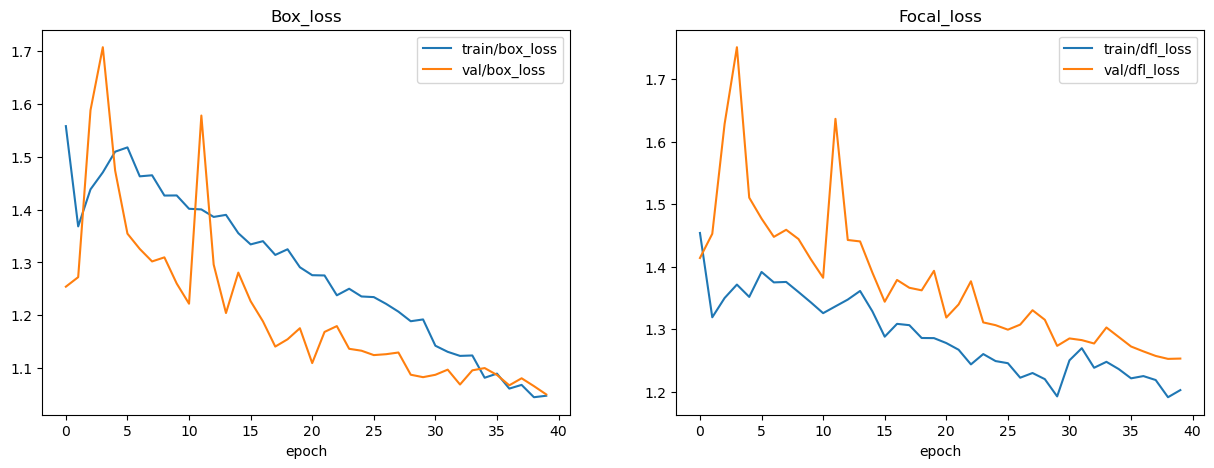

In [7]:
# plot relevant metrics and losses
loss_plots = ['train/box_loss', 'train/dfl_loss', 'val/box_loss', 'val/dfl_loss']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i in range(2):
    train_results.plot(x='epoch', y=loss_plots[i], ax=axes[i])
for i in range(2):
    train_results.plot(x='epoch', y=loss_plots[i+2], ax=axes[i])

axes[0].set_title('Box_loss')
axes[1].set_title('Focal_loss')

Losses are both pretty turbulent in the initial epochs but gradually tapers off in a downward trend. Train and validation losses (for both box and focal loss) reduces as the number of epoch increases, implying good fit.

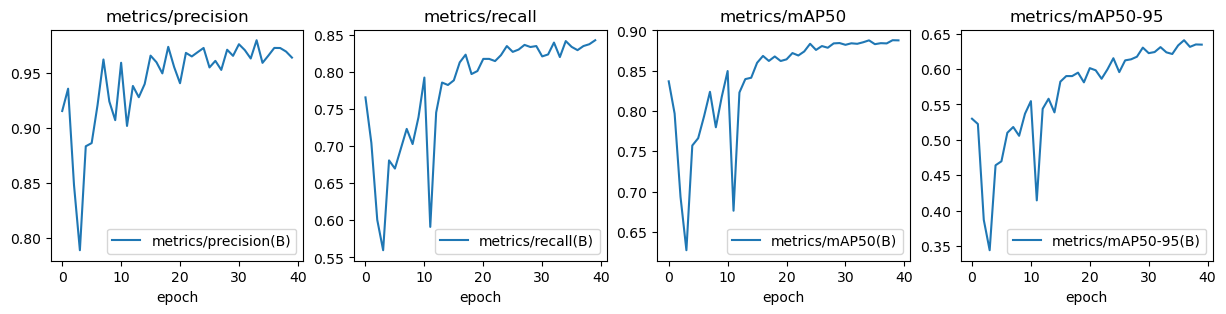

In [8]:
metric_plots = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))

for i in range(4):
    train_results.plot(x='epoch', y=metric_plots[i], ax=axes[i])
    axes[i].set_title(metric_plots[i][:-3])

Similarly, the meterics are turbulent in the intial epochs but taper off in an upward trend, implying that the model is training well.

In [9]:
# validate the model
model = YOLO("yolov8/train/weights/best.pt")
results = model.val(data='yolov8/dataset.yaml', imgsz=512, save_json=True, plots=True, save=True, workers=0)  # evaluate model performance on the validation set

Ultralytics YOLOv8.0.18  Python-3.9.13 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 8192MiB)
Model summary (fused): 268 layers, 43607379 parameters, 0 gradients, 164.8 GFLOPs
val: Scanning C:\Users\User\Desktop\Capstone - Aircraft Detection\datasets\data\labels\val.cache... 425 images, 201 backgrounds, 0 corrupt: 100%|██████████| 425/425 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.83it/s]
                   all        425        636      0.971      0.828      0.884      0.641
Speed: 0.1ms pre-process, 15.0ms inference, 0.0ms loss, 0.7ms post-process per image
Saving runs\detect\val4\predictions.json...


Precision: 0.971, Recall: 0.828, mAP50: 0.884, mAP50-95: 0.641

---
The next part, part4, is the final notebook where we evaluate the trained models.